<a href="https://colab.research.google.com/github/krishnakaushik25/handwritten_digit_recognizer-DL/blob/master/(VGG%2CInception%2CXception).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CNN comparison (VGG,Inception,Xception)

In [ ]:
##Load Data
import numpy as np
import pandas as pd

input_train = pd.read_csv("/content/drive/My Drive/train.csv")
input_test = pd.read_csv("/content/drive/My Drive/test.csv")
print("Train data Shape : "+str(input_train.shape))
print("Test data Shape : "+str(input_test.shape))
#Check any missing data
print("Any missing data : "+str(np.any(input_train.isnull().sum())))
input_train.head(2)

Train data Shape : (42000, 785)
Test data Shape : (28000, 784)
Any missing data : False


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
##Prepare
Y_train = input_train["label"]
X_train = input_train.drop(labels = ["label"],axis = 1) 
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
print("Features Shape : "+str(X_train.shape))
print("Labels Shape : "+str(Y_train.shape))
input_train.groupby("label",axis=0).size()

del input_train # free some space
#View Sample
import matplotlib.pyplot as plt
%matplotlib inline

Features Shape : (42000, 28, 28, 1)
Labels Shape : (42000,)


In [ ]:
#Normalize
X_train = X_train / 255
X_train  = X_train.round()
input_test = input_test / 255
input_test  = input_test.round()

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
Y_train = to_categorical(Y_train, num_classes = 10)

Using TensorFlow backend.


In [ ]:
from sklearn.model_selection import train_test_split
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
###Loading libraries
from keras.models import Sequential, Model
from keras.layers import Input,concatenate,DepthwiseConv2D,Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

In [ ]:
def evaluate_model(model,X_train,Y_train,X_val,Y_val,saveModelName,epochs,batch_size):
    filepath=saveModelName+".hdf5"
    best_accuracy_model = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
    history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,best_accuracy_model]) 
    model.load_weights(filepath)
    return model,history

In [ ]:
## Plotting train and test accuracy/loss
def plot_results(history):
    fig, ax = plt.subplots(2,1)
    ax[0].plot(history.history['loss'], color='b', label="Training loss")
    ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
    legend = ax[0].legend(loc='best', shadow=True)

    ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
    ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
    legend = ax[1].legend(loc='best', shadow=True)
    
# Saving results
result_table_columns = ['CNN Model','Train Accuracy','Test Accuracy']
results = pd.DataFrame(columns=result_table_columns)

def add_result(name,history,results,row):
    results.loc[row,'CNN Model'] = name
    results.loc[row,'Train Accuracy'] = history.history['accuracy'][np.argmax(history.history['val_accuracy'])]
    results.loc[row,'Test Accuracy'] = max(history.history['val_accuracy'])
    return results

In [ ]:
##First we try with simple model with no shape reformating
def singelHiddenLayer(pixelcount):
    model = Sequential()
    model.add(Dense(pixelcount, input_dim=pixelcount, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

flat_X_train = X_train.reshape((X_train.shape[0],-1))
model = singelHiddenLayer(flat_X_train.shape[1])
model.fit(flat_X_train, Y_train,epochs=15, batch_size=200, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
 - 3s - loss: 0.3645 - accuracy: 0.8947
Epoch 2/15
 - 1s - loss: 0.1481 - accuracy: 0.9584
Epoch 3/15
 - 1s - loss: 0.0944 - accuracy: 0.9734
Epoch 4/15
 - 1s - loss: 0.0627 - accuracy: 0.9828
Epoch 5/15
 - 1s - loss: 0.0424 - accuracy: 0.9898
Epoch 6/15
 - 1s - loss: 0.0288 - accuracy: 0.9939
Epoch 7/15
 - 1s - loss: 0.0192 - accuracy: 0.9963
Epoch 8/15
 - 1s - loss: 0.0131 - accuracy: 0.9983
Epoch 9/15
 - 1s - loss: 0.0088 - accuracy: 0.9995
Epoch 10/15
 - 1s - loss: 0.0060 - accuracy: 0

In [ ]:
##To get Idea start with simple CNN model
#[[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
#Method decription
# 2C = 2 Conv2D
# M = MaxPool2D
# Dr = Dropout
# F = Flatten
# D = Dense
def model_2CMDr_2CMDr_FDDr_D():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'same', activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    print(model.summary())
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)         

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.973288,0.990952


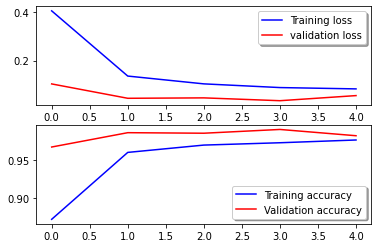

In [ ]:
epochs = 5 # Change this to 35 for best results
model = model_2CMDr_2CMDr_FDDr_D()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_2CMDr_2CMDr_FDDr_D.best",epochs,64)
plot_results(history)

results = add_result("2CMDr_2CMDr_FDDr_D",history,results,0)
results

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0   

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.973288,0.990952
1,vgg_64_4,0.97297,0.987857


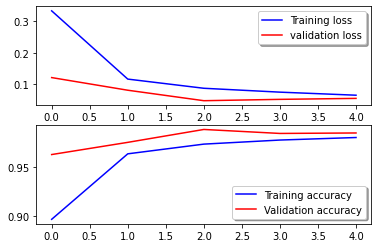

In [ ]:
def vgg_model(n_filters,n_conv):
    visible = Input(shape=(28, 28, 1))
    layers= visible
    for _ in range(n_conv):
        layers = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layers)
    #add max pooling layer
    layers = MaxPooling2D((2,2), strides=(2,2))(layers)
    layers = Flatten()(layers)
    output = Dense(10,activation='softmax')(layers)
    model = Model(inputs=visible, outputs=output)
    print(model.summary())
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = vgg_model(64,4)
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_vgg_64_4.best",epochs,64)
plot_results(history)
results = add_result("vgg_64_4",history,results,1)
results

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_3 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 32)       

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.973288,0.990952
1,vgg_64_4,0.97297,0.987857
2,vgg_batchNormalize,0.968147,0.987857


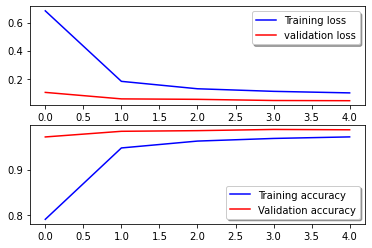

In [ ]:
def model_vgg_batchNormalize():
    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=3,activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_size=3,activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(10, activation='softmax'))
    print(model.summary())
    
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

model = model_vgg_batchNormalize()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_vgg_batchNormalize.best",epochs,64)
plot_results(history)
results = add_result("vgg_batchNormalize",history,results,2)
results

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 28, 28, 16)   32          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 28, 28, 16)   32          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 28, 28, 1)    0           input_2[0][0]                    
____________________________________________________________________________________________

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.973288,0.990952
1,vgg_64_4,0.97297,0.987857
2,vgg_batchNormalize,0.968147,0.987857
3,Inception,0.973262,0.984762


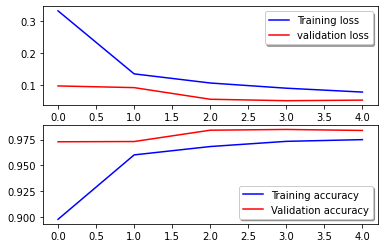

In [ ]:
def model_Inception():
    input_img = Input(shape=(28, 28, 1))
    # Layer 1
    layer1_tower_0 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    layer1_tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    layer1_tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(layer1_tower_1)
    
    layer1_tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input_img)
    layer1_tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(layer1_tower_2)

    layer1_tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_img)
    layer1_tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_tower_3)

    layer1_output = concatenate([layer1_tower_1, layer1_tower_2, layer1_tower_3, layer1_tower_0], axis=1)

    # Layer 2
    layer2_tower_0 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
    layer2_tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
    layer2_tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(layer2_tower_1)

    layer2_tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer1_output)
    layer2_tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(layer2_tower_2)

    layer2_tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(layer1_output)
    layer2_tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(layer2_tower_3)

    layer2_output = concatenate([layer2_tower_1, layer2_tower_2, layer2_tower_3, layer2_tower_0], axis=1)

    # Flatten & Dense
    layer2_output = Flatten()(layer2_output)
    output = Dense(10,activation='softmax')(layer2_output)
    
    inception_Model = Model(inputs=input_img,outputs=output)
    
    print(inception_Model.summary())
    inception_Model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return inception_Model

model = model_Inception()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_Inception.best",epochs,64)
plot_results(history)
results = add_result("Inception",history,results,3)
results

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 14, 14, 32)   128         conv2d_30[0][0]                  
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 14, 14, 32)   0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.973288,0.990952
1,vgg_64_4,0.97297,0.987857
2,vgg_batchNormalize,0.968147,0.987857
3,Inception,0.973262,0.984762
4,Xception,0.960621,0.979762


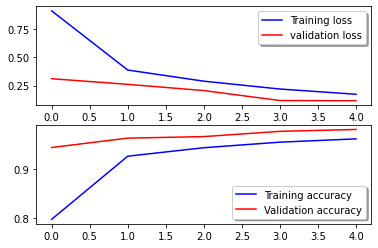

In [ ]:
def model_Xception():
    inp = Input(shape = (28, 28, 1))
    x = inp
    x = Conv2D(32, (3, 3), strides = 2, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(64, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)

    x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = DepthwiseConv2D((3, 3), (1, 1), padding = "same", activation = "relu")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = MaxPooling2D((2, 2), strides = 1)(x1)

    x = concatenate([x1, Conv2D(64, (2, 2), strides = 1)(x)])

    x1 = Activation("relu")(x)
    x1 = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same", activation = "relu")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = DepthwiseConv2D((3, 3), strides = 1, padding = "same")(x1)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x1 = MaxPooling2D((2, 2), strides = 1)(x1)

    x = concatenate([x1, Conv2D(256, (2, 2), strides = 1)(x)])

    x = Activation("relu")(x)
    x = Conv2D(256, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(128, (3, 3), strides = 1, padding = "same", activation = "relu")(x)
    x = BatchNormalization(axis = 3)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)

    x = Dense(10, activation = "softmax")(x)

    xception = Model(inp, x)
    print(xception.summary())
    xception.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return xception

model = model_Xception()
print("Starting evaluation")
model,history = evaluate_model(model,X_train,Y_train,X_val,Y_val,"model_Xception.best",epochs,64)
plot_results(history)
results = add_result("Xception",history,results,4)
results

In [ ]:
results

,CNN Model,Train Accuracy,Test Accuracy
0,2CMDr_2CMDr_FDDr_D,0.973288,0.990952
1,vgg_64_4,0.97297,0.987857
2,vgg_batchNormalize,0.968147,0.987857
3,Inception,0.973262,0.984762
4,Xception,0.960621,0.979762


In [ ]:
## predict results
# model = model_2CMDr_2CMDr_FDDr_D()  #99.214%
# model = vgg_model(64,4) #99.476%
model = model_vgg_batchNormalize()  #99.73%
# model = model_Inception()  #99.21%
# model = model_Xception()  #99.57%

model.load_weights("model_vgg_batchNormalize.best.hdf5")

test_data = input_test.values.reshape(-1,28,28,1)
outputs = model.predict(test_data)

# select the index with the maximum probability
outputs = np.argmax(outputs,axis = 1)

outputs = pd.Series(outputs,name="Label")
outputs

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
batch_normalization_23 (Batc (None, 24, 24, 32)        128       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 12, 12, 32)       

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [ ]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),outputs],axis = 1)

#submission.to_csv("submision_Inception.csv",index=False)
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
